In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('/Users/shanmugapriyan/Downloads/csv_preprocessed.csv')

In [3]:
X = data.drop(columns=["Attack Type"])

In [4]:
Y = data["Attack Type"]

In [5]:
def mutual_info(X, Y):
  mutual_info_arr = mutual_info_classif(X, Y)
  series_info = pd.Series(mutual_info_arr)
  series_info.index = X.columns
  series_top = series_info.sort_values(ascending=False)[:25]
  return series_top

<Axes: >

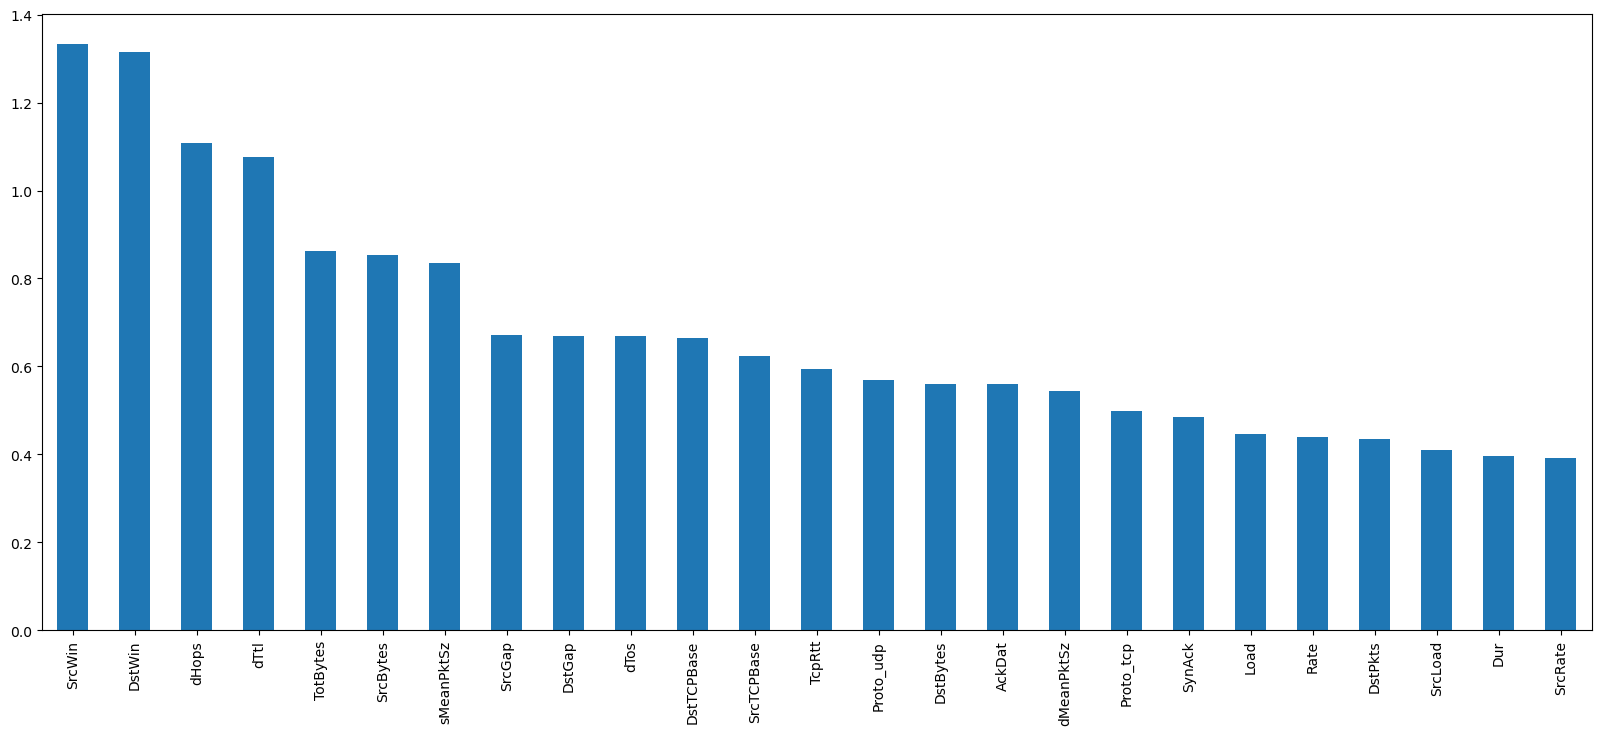

In [6]:
result = mutual_info(X, Y)
result.plot.bar(figsize=(20,8))

In [7]:
new_data = data[result.keys()]
new_data.head()

,SrcWin,DstWin,dHops,dTtl,TotBytes,SrcBytes,sMeanPktSz,SrcGap,DstGap,dTos,...,AckDat,dMeanPktSz,Proto_tcp,SynAck,Load,Rate,DstPkts,SrcLoad,Dur,SrcRate
0,3.442533e-07,6.217791e-08,-0.973059,-0.00732,-0.117591,-0.099523,0.164660,-0.00383,-0.006334,-0.094739,...,-0.388062,-0.287785,0.0,-0.044552,-0.008291,-0.010846,-0.115856,-0.010654,-0.807085,-0.010638
1,3.442533e-07,6.217791e-08,-0.973059,-0.00732,-0.117591,-0.099523,0.164660,-0.00383,-0.006334,-0.094739,...,-0.388062,-0.287785,0.0,-0.044552,-0.008291,-0.010846,-0.115856,-0.010654,-0.807085,-0.010638
2,3.442533e-07,6.217791e-08,-0.973059,-0.00732,8.131316,9.877388,8.044846,-0.00383,-0.006334,-0.094739,...,-0.388062,0.972879,0.0,-0.044552,-0.007624,-0.010347,1.327973,0.019071,2.147963,-0.008894
3,3.442533e-07,6.217791e-08,-0.973059,-0.00732,7.224216,8.734380,8.598644,-0.00383,-0.006334,-0.094739,...,-0.388062,0.922515,0.0,-0.044552,-0.007698,-0.010417,1.568612,0.015639,2.147973,-0.009189
4,3.442533e-07,6.217791e-08,-0.973059,-0.00732,9.162383,11.165238,8.769752,-0.00383,-0.006334,-0.094739,...,-0.388062,0.811590,0.0,-0.044552,-0.007541,-0.010326,1.408186,0.022903,2.148810,-0.008823


In [35]:
result.keys()

Index(['SrcWin', 'DstWin', 'dHops', 'dTtl', 'TotBytes', 'SrcBytes',
       'sMeanPktSz', 'SrcGap', 'DstGap', 'dTos', 'DstTCPBase', 'SrcTCPBase',
       'TcpRtt', 'Proto_udp', 'DstBytes', 'AckDat', 'dMeanPktSz', 'Proto_tcp',
       'SynAck', 'Load', 'Rate', 'DstPkts', 'SrcLoad', 'Dur', 'SrcRate'],
      dtype='object')

In [8]:
# # Hard coding now to skip the mutual information step
# new_data = data[["SrcWin", "DstWin", "dHops", "dTtl", "TotBytes", "SrcBytes", "sMeanPktSz", "DstGap", "SrcGap", "dTos", "DstTCPBase", "SrcTCPBase", "TcpRtt", "Proto_udp", "DstBytes", "AckDat" , "dMeanPktSz", "Proto_tcp", "SynAck", "Load"]]
# new_data.head()

In [9]:
def concat_column_for_plot(pca_data, column_name):
  for_plot = pd.concat([pca_data, data[column_name]], axis = 1)
  return for_plot

In [10]:
new_data = concat_column_for_plot(new_data, "Attack Type")

In [11]:
X_train, X_test, y_train, y_test = train_test_split(new_data.loc[:, new_data.columns != 'Attack Type'], new_data['Attack Type'],
                                                    stratify=new_data['Attack Type'],
                                                    test_size=0.15)

X_train = pd.DataFrame(X_train, columns=new_data.columns.to_list()[:-1])
X_test = pd.DataFrame(X_test, columns=new_data.columns.to_list()[:-1])
y_train = pd.DataFrame(y_train, columns=['Attack Type'])
y_test = pd.DataFrame(y_test, columns=['Attack Type'])

print("Training dataset size:", X_train.shape)
print("Testing dataset size:", X_test.shape)
print("Training target size:", y_train.shape)
print("Testing target size:", y_test.shape)

Training dataset size: (1033323, 25)
Testing dataset size: (182352, 25)
Training target size: (1033323, 1)
Testing target size: (182352, 1)


In [12]:
def get_pca_df(scaled_data, no_of_components):
  pca = PCA(n_components=no_of_components)
  Principal_components=pca.fit_transform(scaled_data)
  column_names = ["PC "+str(i) for i in range(1, no_of_components+1)]
  pca_df = pd.DataFrame(data = Principal_components, columns = column_names)
  return pca_df, pca

In [13]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [14]:
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
Y = new_data['Attack Type']
X_train, pca = get_pca_df(X_train, 15)
for train_index, test_index in skf.split(X_train, y_train):
    X1_train, X1_test = X_train.iloc[train_index], X_train.iloc[test_index]
    y1_train, y1_test = y_train.iloc[train_index], y_train.iloc[test_index]
    # Initialize kNN classifier
    knn = KNeighborsClassifier(n_neighbors=19)
    # Train the classifier
    knn.fit(X1_train, y1_train)
    # Predict on the test set
    y_pred = knn.predict(X1_test)
    # Calculate evaluation metrics and store them
    accuracy_scores.append(accuracy_score(y1_test, y_pred))
    precision_scores.append(precision_score(y1_test, y_pred, average='weighted'))
    recall_scores.append(recall_score(y1_test, y_pred, average='weighted'))
    f1_scores.append(f1_score(y1_test, y_pred, average='weighted'))

In [15]:
x_test = pca.transform(X_test)


In [16]:
x_test

array([[-0.27473377, -0.6053312 ,  0.2888265 , ...,  0.03564467,
        -0.16141811, -0.24976437],
       [-0.16372504, -0.28474657,  0.30523664, ...,  0.16344132,
        -0.34342668,  0.30778819],
       [-0.17460421, -0.31617306,  0.30371712, ...,  0.15087144,
        -0.32551392,  0.25298746],
       ...,
       [-0.27027935, -0.5165974 ,  0.60832576, ...,  0.12701339,
         0.40733552,  0.19178062],
       [-0.09810704, -0.09522847,  0.31530833, ...,  0.23881175,
        -0.4507249 ,  0.63677872],
       [ 0.22172291,  0.55754587,  3.34089293, ..., -0.2872762 ,
         1.01592348,  0.83965334]])

In [17]:
y1_pred = knn.predict(x_test)

In [18]:
accuracy_score(y_test, y1_pred)

0.9920538299552514

In [19]:
accuracy_scores

[0.9919483221638884,
 0.9919821934047856,
 0.992432197033847,
 0.9924902256803314,
 0.9921660279487478]

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
# Compute and print the confusion matrix
conf_matrix = confusion_matrix(y_test, y1_pred)
print('Confusion Matrix:')
print(conf_matrix)

Confusion Matrix:
[[71595    18     0     0     0    13     2     1     0]
 [    1 20480     0     0     0   641     0     0     0]
 [    0     0   173     0     0     0     0     0     0]
 [    0     1     0  1445    12     0     0     0     0]
 [    0     0     0     5  2995     0     2     0     4]
 [    0   712     0     3     0 10226    28     0     0]
 [    0     0     0     0     2     1  3004     0     1]
 [    0     0     0     0     0     0     0 68601     0]
 [    0     0     0     0     2     0     0     0  2384]]


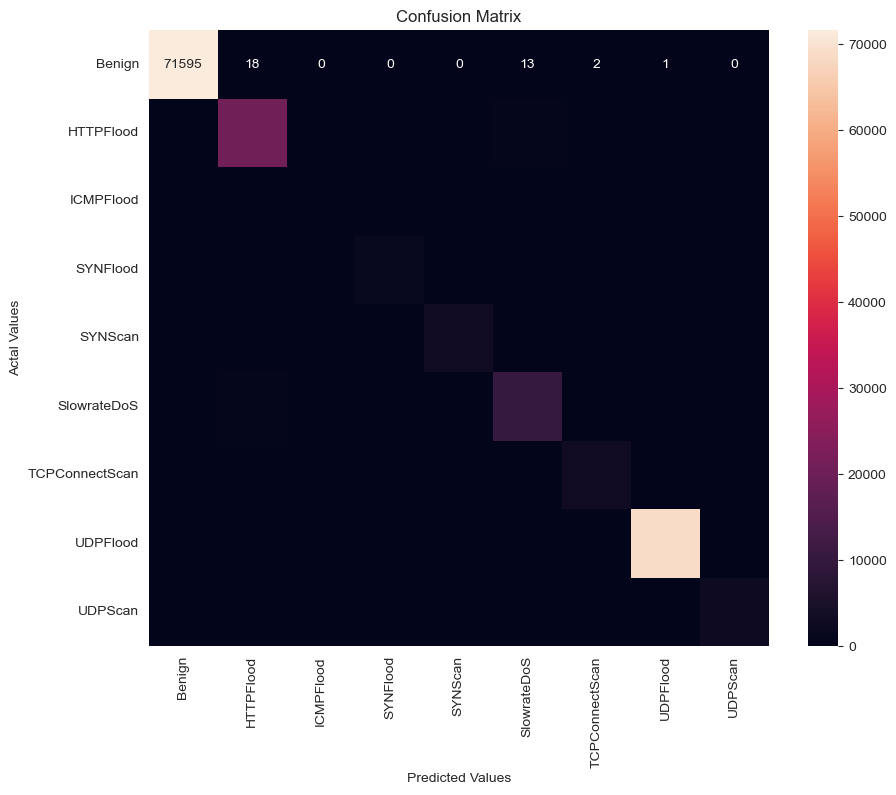

In [37]:
le_name_mapping = {'Benign': 0, 'HTTPFlood': 1, 'ICMPFlood': 2, 'SYNFlood': 3, 'SYNScan': 4, 'SlowrateDoS': 5, 'TCPConnectScan': 6, 'UDPFlood': 7, 'UDPScan': 8}

from sklearn.metrics import confusion_matrix

# Creating  a confusion matrix,which compares the y_test and y_pred
cm = confusion_matrix(y_test, y1_pred)

# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = le_name_mapping.keys(), 
                     columns = le_name_mapping.keys())

#Plotting the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [25]:
from sklearn.metrics import precision_score

precision = precision_score(y_test, y1_pred, average='weighted') # Use 'binary' for binary classification
print(f'Precision: {precision}')

Precision: 0.9920432455889213


In [26]:
from sklearn.metrics import recall_score

recall = recall_score(y_test, y1_pred, average='weighted') # Use 'binary' for binary classification
print(f'Recall: {recall}')

Recall: 0.9920538299552514


In [27]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y1_pred, average='weighted') # Use 'binary' for binary classification
print(f'F1 Score: {f1}')

F1 Score: 0.9920467164091965


In [29]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y1_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.9920538299552514


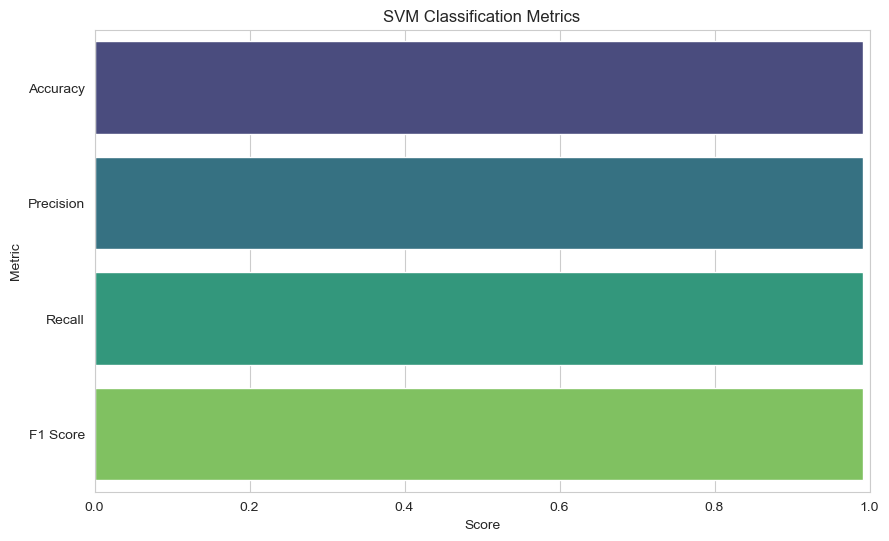

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming metrics are stored in these variables
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1,
    # 'ROC-AUC': roc_auc  # Uncomment if ROC-AUC is applicable and calculated
}

# Convert dictionary to lists for plotting
metric_names = list(metrics.keys())
metric_values = [metrics[metric] for metric in metric_names]

# Create bar plot
sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x=metric_values, y=metric_names, palette="viridis")

plt.xlabel('Score')
plt.ylabel('Metric')
plt.title('SVM Classification Metrics')
plt.xlim(0, 1)  # Assuming the scores are between 0 and 1
plt.show()